In [77]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
import pandas as pd

# TIMESTAMP 열을 datetime으로 변환
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])

# TIMESTAMP 기준으로 오름차순 정렬
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

max_gap = pd.Timedelta(minutes=10)
time_offsets = [3, 5, 9]
time_based_data = {hour: [] for hour in time_offsets}

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue

    start_time = group["TIMESTAMP"].min()

    for hour in time_offsets:
        target_time = start_time + pd.Timedelta(hours=hour)
        time_diff = (group["TIMESTAMP"] - target_time).abs()
        closest_idx = time_diff.idxmin()
        if time_diff[closest_idx] <= max_gap:
            closest_row = group.loc[closest_idx]
            time_based_data[hour].append(closest_row)

# 시점별로 DataFrame으로 정리
df_3h = pd.DataFrame(time_based_data[3]).reset_index(drop=True)
df_5h = pd.DataFrame(time_based_data[5]).reset_index(drop=True)
df_9h = pd.DataFrame(time_based_data[9]).reset_index(drop=True)

In [69]:
dataframes = {'5h': df_5h}

In [79]:
selected_names = ['lr', 'rf', 'xgb']

In [81]:
base_classifiers = {
    'lr': LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', random_state=42),
    'rf': RandomForestClassifier(class_weight='balanced', random_state=42),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

In [98]:
param_grids = {
    'lr': {
        'C': [0.1, 0.5, 1.0],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced'],
        'max_iter': [1000]
    },
    'rf': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 3],
        'class_weight': ['balanced']
    },
    'xgb': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'scale_pos_weight': [1],  # 불균형 비율 맞춰 조정 가능
        'eval_metric': ['mlogloss'],
        'use_label_encoder': [False]
    }
}


In [100]:
def evaluate_first_stage_classifier(dataframes):
    results_summary = []

    for time_label, df_selected in dataframes.items():
        print(f"\n=== {time_label} 데이터 기반 CLUSTER_1 예측 (1차 분류기) ===")

        X = df_selected[['LAT', 'LON', 'COG', 'HEADING']]
        y = df_selected['CLUSTER_1']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

        best_classifiers = {}
        for name in selected_names:
            clf = base_classifiers[name]
            grid = GridSearchCV(clf, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_classifiers[name] = grid.best_estimator_
            print(f"✅ {name} Best Score: {grid.best_score_:.4f} | Best Params: {grid.best_params_}")

        estimators = [(name, best_classifiers[name]) for name in selected_names]
        voting_model = VotingClassifier(estimators=estimators, voting='soft')
        voting_model.fit(X_train, y_train)

        y_pred = voting_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n🎯 정확도 (테스트셋): {acc:.4f}")

        labels = sorted(y.unique())
        label_names = [str(lbl) for lbl in labels]
        cm = confusion_matrix(y_test, y_pred, labels=labels)
        cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"Confusion Matrix - {time_label}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        print("\n📋 테스트 데이터 분류 리포트:")
        print(classification_report(y_test, y_pred, target_names=label_names))

        report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
        print("\n📊 CLUSTER_1 클래스별 정확도:")
        for label in label_names:
            acc = report[label]['precision']
            recall = report[label]['recall']
            f1 = report[label]['f1-score']
            print(f" - CLUSTER_1 = {label} → 정확도(정밀도): {acc:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}")
        cv_scores = cross_val_score(voting_model, X_train, y_train, cv=5, scoring='accuracy')
        print(f"\n📊 교차검증 정확도 평균: {cv_scores.mean():.4f}, 표준편차: {cv_scores.std():.4f}")

        cv_pred = cross_val_predict(voting_model, X_train, y_train, cv=5)
        print("\n📋 교차검증 기반 분류 리포트:")
        print(classification_report(y_train, cv_pred, target_names=label_names))

        results_summary.append({
            'time': time_label,
            'accuracy': acc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        })

    return pd.DataFrame(results_summary)


=== 5h 데이터 기반 CLUSTER_1 예측 (1차 분류기) ===
✅ lr Best Score: 0.6329 | Best Params: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
✅ rf Best Score: 0.7252 | Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
✅ xgb Best Score: 0.7117 | Best Params: {'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8, 'use_label_encoder': False}

🎯 정확도 (테스트셋): 0.7589


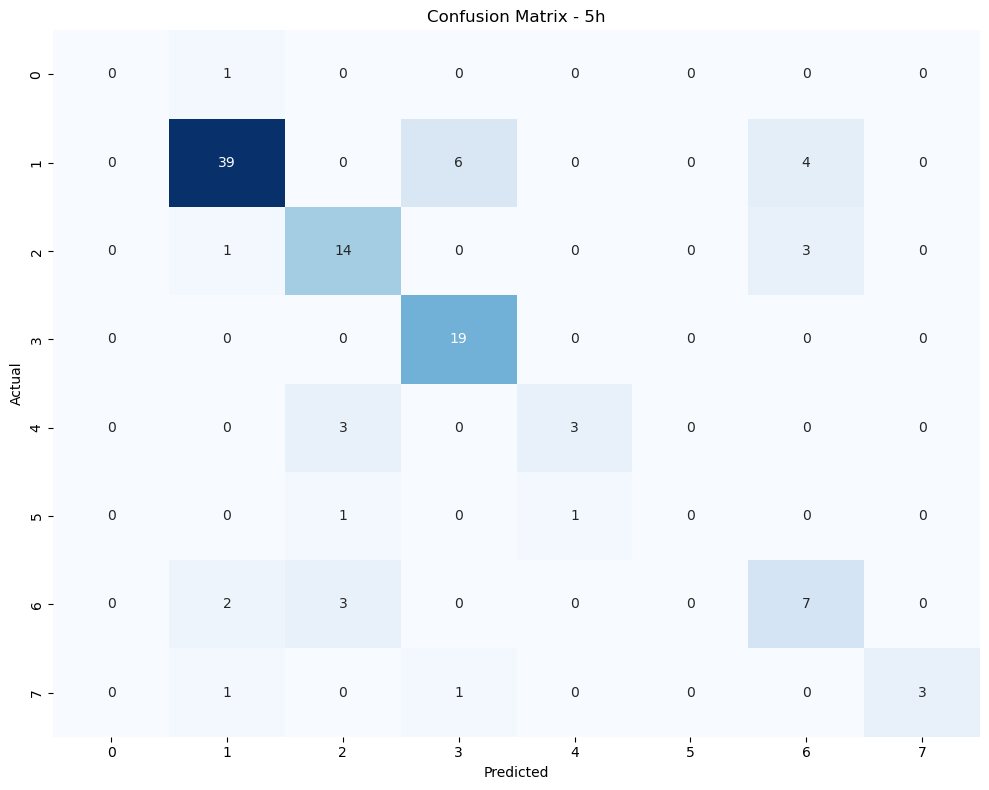


📋 테스트 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.89      0.80      0.84        49
           2       0.67      0.78      0.72        18
           3       0.73      1.00      0.84        19
           4       0.75      0.50      0.60         6
           5       0.00      0.00      0.00         2
           6       0.50      0.58      0.54        12
           7       1.00      0.60      0.75         5

    accuracy                           0.76       112
   macro avg       0.57      0.53      0.54       112
weighted avg       0.76      0.76      0.75       112


📊 CLUSTER_1 클래스별 정확도:
 - CLUSTER_1 = 0 → 정확도(정밀도): 0.0000, 재현율: 0.0000, F1: 0.0000
 - CLUSTER_1 = 1 → 정확도(정밀도): 0.8864, 재현율: 0.7959, F1: 0.8387
 - CLUSTER_1 = 2 → 정확도(정밀도): 0.6667, 재현율: 0.7778, F1: 0.7179
 - CLUSTER_1 = 3 → 정확도(정밀도): 0.7308, 재현율: 1.0000, F1: 0.8444
 - CLUSTER_1 = 4 → 정확도(정밀도): 0.7500, 재현율: 0.5000, F1: 0.6000
 -

In [101]:
results_df = evaluate_first_stage_classifier(dataframes)